In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions

Using TensorFlow backend.


In [2]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import keras

In [3]:
#model = InceptionV3(weights='imagenet', include_top=True)

In [4]:
print("model structure: ", model.summary())
print("model weights: ", model.get_weights())

NameError: name 'model' is not defined

In [7]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(400, 125, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    
    conv_out1 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(model.output)
    drop1 = keras.layers.Dropout(.1)(conv_out1)
    pooled_out1 = keras.layers.MaxPooling2D((2,2),  padding='same')(drop1)
    #conv_out2 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pooled_out1)
    #drop2 = keras.layers.Dropout(.1)(conv_out2)
    #pooled_out2 = keras.layers.MaxPooling2D((1,1),  padding='same')(drop2)
    #conv_out3 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pooled_out2)
    #drop3 = keras.layers.Dropout(.1)(conv_out3)
    #pooled_out3 = keras.layers.MaxPooling2D((1,1),  padding='same')(drop3)
    #conv_out4 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pooled_out3)
    #drop4 = keras.layers.Dropout(.1)(conv_out4)
    #pooled_out4 = keras.layers.MaxPooling2D((1,1),  padding='same')(drop4)
    
    reshape_layer = keras.layers.Reshape((6, 64))(pooled_out1)
    #new_output = keras.layers.GlobalAveragePooling2D(32)(model.output)
    
    #pooled_out = keras.layers.MaxPooling2D((2,2),  padding='same')(new_output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(36, activation='softmax')(reshape_layer)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [8]:
model = inception()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 125, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 199, 62, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 199, 62, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 199, 62, 32)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-1]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [27]:
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [28]:
model_filename = 'captcha.{0:03d}.hdf5'
last_finished_epoch = None

In [29]:
import os
import string

In [30]:
characters = string.ascii_lowercase+"0123456789"

In [31]:
inp_dir ='E:\\data_for_captcha\\temp\\'

In [32]:
all_images = os.listdir(inp_dir)

In [33]:
len(all_images)

10000

In [34]:
all_images = all_images[:1000]

In [35]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
def preprocess_data():
    
    inp_x = np.zeros((len(all_images), 400,125,3))
    inp_y = np.zeros((len(all_images), 6,len(characters)))
    for idx, image in enumerate(all_images):
        # ----------------prepare input container
        
        #print("image",image)
        img = cv2.imread(inp_dir+image)
        #print(img.shape)
        plt.imshow(img)
        
        img = cv2.resize(img, (400,125), interpolation = cv2.INTER_AREA)
        #print(np.max(img))
        plt.imshow(img)
        #print(img.shape)
        
        # ---------------------Scale images --------------
        
        img = img/255.0
        
        image_txt = image[0:6]
        target_oht = np.zeros((5,len(characters)))
        if(len(image_txt)<7):
            img = np.reshape(img, (400,125,3))
            inp_x[idx] = img
            
             # ------------------Define targets and code them using OneHotEncoding
            target_oht = np.zeros((6,len(characters)))
            for k, char in enumerate(image_txt):
                target_oht[k, characters.find(char)] = 1
            inp_y[idx] = target_oht
    return inp_x, inp_y

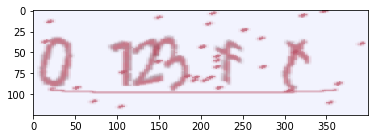

In [37]:
X, Y = preprocess_data()

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
train_x ,test_x, train_y ,test_y = train_test_split(X,Y, shuffle = True, test_size = .15)

In [40]:
train_x.shape,train_y.shape, test_x.shape,test_y.shape

((850, 400, 125, 3), (850, 6, 36), (150, 400, 125, 3), (150, 6, 36))

In [41]:
hist = model.fit(train_x, train_y, batch_size=32, epochs=50,verbose=2, validation_data=(test_x, test_y))

Train on 850 samples, validate on 150 samples
Epoch 1/50
 - 328s - loss: 2.4243 - acc: 0.4363 - val_loss: 7.9589 - val_acc: 0.2500
Epoch 2/50
 - 313s - loss: 2.2390 - acc: 0.5055 - val_loss: 3.5324 - val_acc: 0.4778
Epoch 3/50
 - 311s - loss: 2.0754 - acc: 0.5514 - val_loss: 2.5974 - val_acc: 0.5633
Epoch 4/50
 - 311s - loss: 1.8238 - acc: 0.5947 - val_loss: 2.3517 - val_acc: 0.5844
Epoch 5/50
 - 311s - loss: 1.6441 - acc: 0.6149 - val_loss: 2.1914 - val_acc: 0.6078
Epoch 6/50
 - 312s - loss: 1.5254 - acc: 0.6475 - val_loss: 2.0281 - val_acc: 0.6300
Epoch 7/50
 - 311s - loss: 1.4135 - acc: 0.6494 - val_loss: 1.9581 - val_acc: 0.6422
Epoch 8/50
 - 310s - loss: 1.4449 - acc: 0.6647 - val_loss: 1.7332 - val_acc: 0.6878
Epoch 9/50
 - 310s - loss: 1.3050 - acc: 0.6843 - val_loss: 1.5560 - val_acc: 0.6744
Epoch 10/50
 - 309s - loss: 1.2552 - acc: 0.7096 - val_loss: 1.4869 - val_acc: 0.7233
Epoch 11/50
 - 309s - loss: 1.2294 - acc: 0.7331 - val_loss: 1.3900 - val_acc: 0.7311
Epoch 12/50
 - 31